In [122]:
import numpy as np
import pandas as pd
from scipy.stats import norm, mannwhitneyu
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

plt.style.use('ggplot')

In [123]:
#загружаем датафрейм
boostrap = pd.read_csv('/home/jupyter-a.kosheleva-14/hw_bootstrap.csv', sep = ';')

In [124]:
#удаляем лишний столбец
boostrap = boostrap.drop('Unnamed: 0', 1)

In [125]:
boostrap

,value,experimentVariant
0,"10,3804953740268",Control
1,"9,54686666784264",Control
2,"11,0882146509904",Control
3,"10,1472740570122",Control
4,"9,78980767524929",Control
...,...,...
995,1000,Treatment
996,1200,Treatment
997,1500,Treatment
998,2000,Treatment


In [126]:
boostrap['value'] = boostrap.value.str.replace(',','.')

In [127]:
#переводим столбец в числовой формат чтобы можно было анализировать данные
boostrap['value'] = boostrap['value'].astype('float')

In [128]:
boostrap.dtypes

value                float64
experimentVariant     object
dtype: object

In [141]:
boostrap

,value,experimentVariant
0,10.380495,Control
1,9.546867,Control
2,11.088215,Control
3,10.147274,Control
4,9.789808,Control
...,...,...
995,1000.000000,Treatment
996,1200.000000,Treatment
997,1500.000000,Treatment
998,2000.000000,Treatment


In [129]:
#отбираем группы - тестовую и контрольную
control_group = boostrap.query('experimentVariant == "Control"')

In [130]:
test_group = boostrap.query('experimentVariant == "Treatment"')

In [131]:
# сначала проведем анализ для среднего значения - копируем код из ноутбука из лекции
def get_bootstrap_mean(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

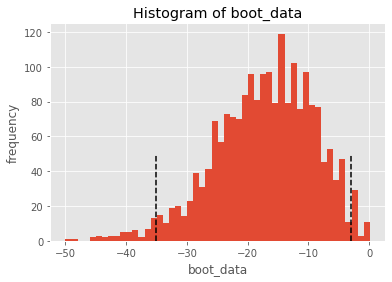

In [132]:
booted_data_mean = get_bootstrap_mean(control_group.value, test_group.value, boot_it = 2000)

In [133]:
booted_data_mean["p_value"]

0.03549948501401971

In [134]:
booted_data_mean["ci"]

,0
0.025,-35.057404
0.975,-3.042428


In [142]:
#Итого по результатам применения бутстрапа со средним значением 0 не входит в доверительный интервал и p-значение меньше 0.05, значит, распределения анализируемой величины в тестовой и контрольной группе значимо различаются.

In [136]:
#Проверим то же самое при помощи критерия Манна-уитни
stat, p = mannwhitneyu(control_group.value, test_group.value)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# интерпретация
alpha = 0.05
if p > alpha:
	print('Same distribution (fail to reject H0)')
else:
	print('Different distribution (reject H0)')

Statistics=124189.500, p=0.430
Same distribution (fail to reject H0)


In [ ]:
#Критерий Манна-Уитни говорит нам, напротив, что значимых различий между распределением признака в тестовой и контрольной группах нет. Это может быть объяснено тем, что критерий менее чувствителен к выбросам, которые у нас имеются в данных

In [137]:
# теперь сделаем то же самое, что и для медианы
def get_bootstrap_median(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

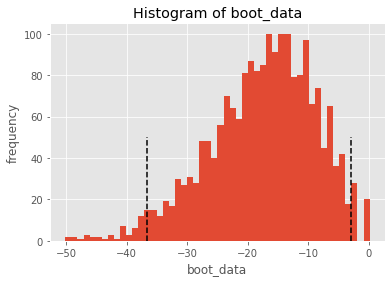

In [138]:
booted_data_median = get_bootstrap_mean(control_group.value, test_group.value, boot_it = 2000)

In [139]:
booted_data_median["p_value"]

0.045626066259222685

In [140]:
booted_data_median["ci"]

,0
0.025,-36.603953
0.975,-2.935294


In [ ]:
#Применение бутстрапа с медианой - результат аналогичен тому, что мы видели, когда применяли его со средним значением - отклоняется нулевая гипотеза. Однако p-значение для медианы выше, т.к. среднее более чувствительно к выбросам.